# Fase 1 - SVM con ProfilingUD (in-genre classification)
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo basata solo su informazioni linguistiche non lessicali estratte utilizzando il sistema Profiling-UD. Riportare i seguenti risultati:
- valutazione del sistema con un processo di 5-fold cross validation condotto sul training
set;
- valutazione del sistema sul test set ufficiale del task;
- elenco delle 15 feature più importanti per la classificazione

Dal task GxG Evalita 2018:

"Given a (collection of) text(s) from a specific genre, the gender of the author has to be predicted. The task is cast as a binary classification task, with gender represented as F (female) or M (male). Gender prediction will be done in two ways: 

1. **using a model which has been trained on the same genre**
2. using a model which has been trained on anything but that genre."

In questo file utilizzeremo un modello allenato sullo stesso genere su cui poi verrà testato.

In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

## Preparazione del dataset

In [5]:
gold_file_path = "../../data/dataset_originale/gold/test_JO.gold"
profiling_output_path = '../../data/profiling_output/journalism/linguistic_profile.csv' # risultati analisi linguistica dei testi del genere scelto

In [6]:
# Caricamento del CSV delle feature linguistiche
def load_dataset(src_path):
    features_names = None
    documents_info = []
    features = []
    
    with open(src_path, 'r') as src_file:
        csv_reader = csv.reader(src_file, delimiter='\t')
        for row in csv_reader:
            if features_names is None: 
                features_names = row[1:]
            else:
                documents_info.append(row[0]) 
                features.append([float(el) for el in row[1:]])
    return features_names, documents_info, features    

In [7]:
features_names, documents_info, features = load_dataset(profiling_output_path)

In [8]:
print("Numero features: " + str(len(features_names)))
print('\nLista prime dieci features:')
print(features_names[:10])

Numero features: 140

Lista prime dieci features:
['n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'ttr_lemma_chunks_100', 'ttr_lemma_chunks_200', 'ttr_form_chunks_100', 'ttr_form_chunks_200', 'upos_dist_ADJ', 'upos_dist_ADP']


In [9]:
print('Primo documento:')
print(f'Document info: {documents_info[0]}')
print('Secondo documento:')
print(f'Document info: {documents_info[1]}')
print('Nono documento:')
print(f'Document info: {documents_info[9]}')
print('\n')
# print("Features names: " + str(features_names[:10]))
print(f'Features: {features[0][:10]}')

Primo documento:
Document info: journalism/training#107#journalism#F.conllu
Secondo documento:
Document info: journalism/training#97#journalism#M.conllu
Nono documento:
Document info: journalism/test#81#journalism#unknown.conllu


Features: [34.0, 769.0, 22.61764705882353, 4.76103500761035, 0.67, 0.64, 0.74, 0.68, 4.811443433029909, 15.604681404421326]


### Creazione lista delle classi (labels)

In [10]:
# Estraggo lo split (training/test), l'ID del testo (66), il genre (journal) e il genere (F/M)

document_info = documents_info[0]
print('Document info:', document_info)

document_info = document_info.split('/')[1]
print('Document info senza cartella:', document_info)

document_info = document_info.split('.')[0]
print('Document info senza estensione:', document_info)

splitted_document_info = document_info.split('#')
print('Split su #:', splitted_document_info)

label = splitted_document_info[2]
print('Label:', label)

Document info: journalism/training#107#journalism#F.conllu
Document info senza cartella: training#107#journalism#F.conllu
Document info senza estensione: training#107#journalism#F
Split su #: ['training', '107', 'journalism', 'F']
Label: journalism


In [11]:
# Creazione delle etichette dai nomi dei file
def create_label_list(documents_info):
    labels = []
    
    for doc_info in documents_info:
        doc_info = doc_info.split('/')[1]
        doc_info = doc_info[0:-len('.conllu')]
        splitted_doc_info = doc_info.split('#')
        genre = splitted_doc_info[2]
        gender = splitted_doc_info[3]
        
        labels.append(gender)
    return labels

In [12]:
labels = create_label_list(documents_info)

In [13]:
def train_test_split(documents_info, features, labels):
    train_features = []
    test_features = []
    train_labels = []
    test_filenames = [] 

    for idx in range(len(documents_info)):
        doc_info = documents_info[idx]
        doc_features = features[idx]
        doc_label = labels[idx]
    
        if 'training' in doc_info:
            train_features.append(doc_features)               
            train_labels.append(doc_label)
        else: # if 'test' in file_name
            test_features.append(doc_features)
            test_filenames.append(doc_info)
            
    return train_features, train_labels, test_features, test_filenames

In [14]:
labels[:10]

['F',
 'M',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'M',
 'F',
 'unknown',
 'unknown']

### Divisione tra training e test set

In [15]:
train_features, train_labels, test_features, test_filenames = train_test_split(documents_info, features, labels)

print('Documenti training set:', len(train_features), len(train_labels))
print('Documenti test set:', len(test_features), len(test_filenames))

Documenti training set: 200 200
Documenti test set: 200 200


## 5-fold cross validation su training set

In [16]:
y_train = np.asarray(train_labels)
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
folds = list(splitter.split(train_features))

In [17]:
print("\n=== Dimensioni dei Fold ===")
for i in range(len(folds)):
    print(f"Fold {i+1}: Training set = {len(folds[i][0])}, Test set = {len(folds[i][1])}")


=== Dimensioni dei Fold ===
Fold 1: Training set = 160, Test set = 40
Fold 2: Training set = 160, Test set = 40
Fold 3: Training set = 160, Test set = 40
Fold 4: Training set = 160, Test set = 40
Fold 5: Training set = 160, Test set = 40


In [18]:
# Liste in cui salviamo le predizioni
all_y_true = []
all_y_pred = []

In [19]:
for i in range(len(folds)):
    train_ids, test_ids = folds[i]

    fold_X_train = np.array(train_features)[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_test = np.array(train_features)[test_ids]
    fold_y_test = y_train[test_ids]

    # Normalizzazione dentro ogni fold (solo con i dati di training del fold)
    scaler = MinMaxScaler()
    fold_X_train = scaler.fit_transform(fold_X_train)
    fold_X_test = scaler.transform(fold_X_test)

    kfold_svc = LinearSVC(dual=False)
    kfold_svc.fit(fold_X_train, fold_y_train)
    fold_y_pred = kfold_svc.predict(fold_X_test)

    fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)

    # Baseline con Dummy Classifier
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(fold_X_train, fold_y_train)
    dummy_score = dummy_clf.score(fold_X_test, fold_y_test)

    all_y_true += fold_y_test.tolist()
    all_y_pred += fold_y_pred.tolist()

    print(f"Accuracy fold {i+1}: {fold_accuracy} \t baseline dummy: {dummy_score}")

Accuracy fold 1: 0.675 	 baseline dummy: 0.45
Accuracy fold 2: 0.7 	 baseline dummy: 0.425
Accuracy fold 3: 0.675 	 baseline dummy: 0.475
Accuracy fold 4: 0.55 	 baseline dummy: 0.425
Accuracy fold 5: 0.675 	 baseline dummy: 0.425



=== Risultati della 5-Fold Cross Validation ===
              precision    recall  f1-score   support

           F       0.66      0.65      0.65       100
           M       0.65      0.66      0.66       100

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200



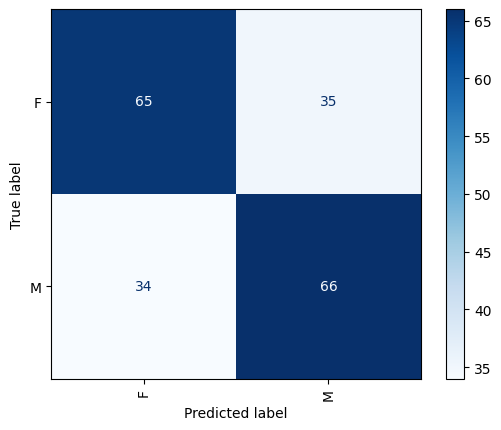

In [20]:
# Report finale della cross-validation
print("\n=== Risultati della 5-Fold Cross Validation ===")
print(classification_report(all_y_true, all_y_pred, zero_division=0))
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, xticks_rotation='vertical', cmap='Blues')

## Addestramento sul training set completo e 

### Normalizzazione

In [21]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_features) # Normalizziamo tutto il training set
X_test = scaler.transform(test_features)

### Training del modello su tutto il training set

In [22]:
svc = LinearSVC(dual=False)
svc.fit(X_train, train_labels)

LinearSVC(dual=False)

### Test del modello su tutto il test set

In [23]:
# Predizioni sul test set
test_predictions = svc.predict(X_test)

In [24]:
# Confronto con Dummy Classifier sul test set
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, train_labels)
dummy_predictions = dummy_clf.predict(X_test)

In [25]:
# Estrazione degli ID dai file di test
test_ids = [name.split("#")[1] for name in test_filenames]  # Estrai solo l'ID numerico

### Valutazione del modello con il gold set

In [26]:
# Caricamento del file GOLD e conversione in DataFrame
gold_df = pd.read_csv(gold_file_path, delimiter="\t", names=["ID", "True_Gender"])

In [27]:
# Creiamo il df con le predizioni
df_output = pd.DataFrame({"ID": test_ids, "Predicted_Gender": test_predictions})
dummy_output = pd.DataFrame({"ID": test_ids, "Dummy_Gender": dummy_predictions})

In [28]:
# Convertiamo entrambe le colonne "ID" in stringa per evitare errori di merge
df_output["ID"] = df_output["ID"].astype(str)
gold_df["ID"] = gold_df["ID"].astype(str)

# Uniamo le predizioni con il gold standard
merged_df = pd.merge(df_output, gold_df, on="ID")
merged_dummy_df = pd.merge(dummy_output, gold_df, on="ID")

### Metriche di valutazione


=== Risultati sul Test Set ===
Accuratezza SVM: 0.5700
Accuratezza Dummy: 0.5000
              precision    recall  f1-score   support

           F       0.56      0.63      0.59       100
           M       0.58      0.51      0.54       100

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.57      0.57      0.57       200



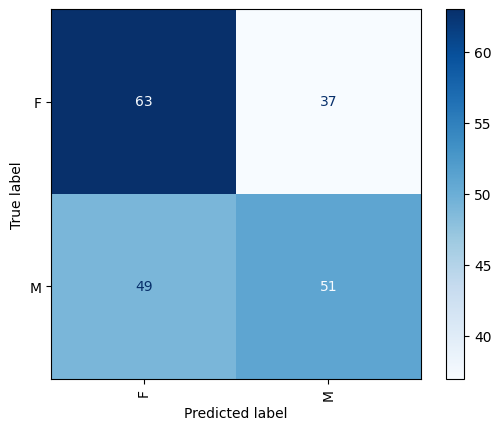

In [29]:
# Calcoliamo le prestazioni
accuracy = accuracy_score(merged_df["True_Gender"], merged_df["Predicted_Gender"])
dummy_accuracy = accuracy_score(merged_dummy_df["True_Gender"], merged_dummy_df["Dummy_Gender"])

print("\n=== Risultati sul Test Set ===")
print(f"Accuratezza SVM: {accuracy:.4f}")
print(f"Accuratezza Dummy: {dummy_accuracy:.4f}")
print(classification_report(merged_df["True_Gender"], merged_df["Predicted_Gender"]))

# Matrice di Confusione
ConfusionMatrixDisplay.from_predictions(
    merged_df["True_Gender"], merged_df["Predicted_Gender"], xticks_rotation='vertical',cmap='Blues');

## 15 features più importanti

In [30]:
coefs = svc.coef_[0]  # Coefficienti della SVM
feature_importances = {feature: abs(coef) for feature, coef in zip(features_names, coefs)}  # Valori assoluti
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:15]  # Primi 15

In [31]:
# Stampiamo le feature più importanti
print("\n=== Top 15 Feature più importanti ===")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")


=== Top 15 Feature più importanti ===
dep_dist_parataxis: 1.6197
n_prepositional_chains: 1.3395
dep_dist_iobj: 1.2660
verbs_form_dist_Inf: 1.1641
char_per_tok: 1.1460
dep_dist_nsubj:pass: 1.0239
verbs_num_pers_dist_Sing+1: 0.9802
dep_dist_csubj: 0.9424
verbs_mood_dist_Imp: 0.9063
aux_num_pers_dist_Sing+1: 0.9054
verbs_tense_dist_Fut: 0.8819
dep_dist_expl: 0.8816
avg_links_len: 0.8442
dep_dist_obl: 0.8258
aux_form_dist_Part: 0.7867


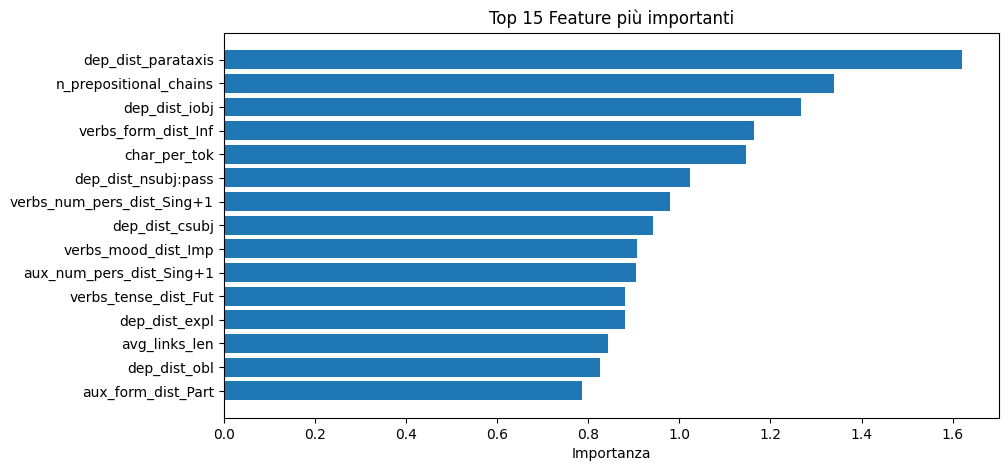

In [32]:
# Plot delle feature più importanti
features, importances = zip(*sorted_features)
plt.figure(figsize=(10, 5))
plt.barh(features, importances, align="center")
plt.xlabel("Importanza")
plt.title("Top 15 Feature più importanti")
plt.gca().invert_yaxis()
plt.show()